In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
from pathlib import Path
import functions as f
from lmfit import Model

In [2]:
INPUT_DIR = Path('./../Plummer/run-')

In [3]:
r_e = np.geomspace(15e-2, 25, 101)

dmdr_3D = pd.DataFrame(data={'r':r_e})

popts_3D = pd.DataFrame()
popts_2D = pd.DataFrame()

### in 3D

In [4]:
def average_random(snap, r_e, gamma_ini, sfe, dim):
    dmdr = 0
    for random in [11, 12, 13, 21, 22, 23, 31, 32, 33]:
        folder = Path(f'./../Plummer/run-0.25-{random}')
        dmdr += f.get_dmdr(folder, snap, r_e, 3)
        
    return dmdr / 9

In [5]:
snapshots = [0, 100, 200, 600]
n = 0

In [7]:
for snap in snapshots:
    
    dmdr = 0
    for i in range(-n, n+1):
        dmdr += average_random(snap + i * 10, r_e, '2.0', '0.20', 3) / (2 * n + 1)
    
    fmodel = Model(f.log_dmdr_profile)
    
    fmodel.set_param_hint('ro0', value=500, min=0.1, max=40000.0)
    fmodel.set_param_hint('a', value=1, min=0.1, max=10.0)
    fmodel.set_param_hint('gamma', value=0.3, min=1e-9, max=3.5)
    fmodel.set_param_hint('beta', value=3.85, min=2, max=7.5)
    fmodel.set_param_hint('alpha', value=1.0, min=0.1, max=6)
    params = fmodel.make_params()
    
    params['dim'].vary = False
    params['dim'].value = 3
    
#     params['alpha'].vary = False
#     params['alpha'].value = 2
    
#     params['beta'].vary = False
#     params['beta'].value = 4
    
    data = np.log10(dmdr)
    result = fmodel.fit(data=data, params=params, r=r_e)
    
    
    dmdr_3D[snap] = dmdr
    popts_3D[snap] = [result.params['ro0'].value, result.params['a'].value, 
                      result.params['gamma'].value, result.params['beta'].value, 
                      result.params['alpha'].value]

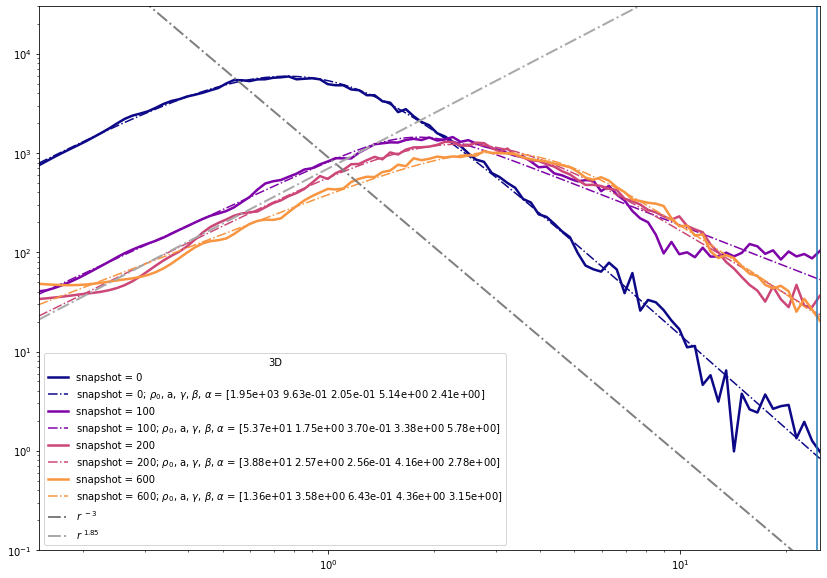

In [8]:
cycol = iter(cm.plasma(np.linspace(0, 1, len(snapshots)+1)))
np.set_printoptions(formatter={'float': "{0:0.2e}".format})

fig, ax = plt.subplots(figsize=(14, 10))
for snap in dmdr_3D.columns[1:]:
    c=next(cycol)
    ax.plot(dmdr_3D['r'], dmdr_3D[snap], label=f'snapshot = {snap}', 
            c=c, lw=2.5)
    ax.plot(dmdr_3D['r'], f.dmdr_profile(dmdr_3D['r'], *popts_3D[snap], 3), 
            c=c, ls='-.', label=fr'snapshot = {snap}; $\rho_0$, a, $\gamma$, $\beta$, $\alpha$ = {popts_3D[snap].values}')
    
ax.plot(dmdr_3D['r'], 900 / dmdr_3D['r'] ** 3, c='gray', label=r'$r^{\ -3}$', ls= '-.', lw=2)
ax.plot(dmdr_3D['r'], 700 * dmdr_3D['r'] ** 1.85 , c='darkgrey', label='$r^{\ 1.85}$', ls= '-.', lw=2)
ax.plot([1.23 * 20, 1.23 * 20], [1e-3, 1e5])   
    
ax.set_ylim(1e-1, 3e4)
ax.set_xlim(r_e.min(), r_e.max())
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title='3D')